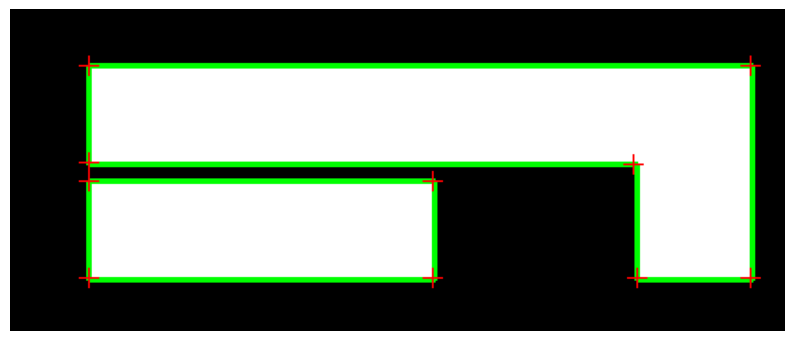

{'Contour 1': [(42, 92), (227, 92), (42, 144), (227, 144)],
 'Contour 2': [(42, 30),
  (398, 30),
  (42, 82),
  (335, 83),
  (337, 144),
  (398, 144)]}

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("image.png", cv2.IMREAD_GRAYSCALE)

# Binary thresholding to detect dark objects
_, thresh = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY_INV)  # Set the threshold value
thresh_corrected = cv2.threshold(thresh, 127, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)

# Find contours and calculate maximum area
contours, _ = cv2.findContours(thresh_corrected, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_area = max(cv2.contourArea(cnt) for cnt in contours)

# Define the minimum area as a percentage of the maximum area
min_area_ratio = 0.1
min_area = max_area * min_area_ratio

# Filter contours based on the minimum area
large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
filtered_image = np.zeros_like(image)
cv2.drawContours(filtered_image, large_contours, -1, (255, 255, 255), thickness=cv2.FILLED)

# Morph. opening to remove thin lines/small protrusions
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
opened_image = cv2.morphologyEx(filtered_image, cv2.MORPH_OPEN, kernel)

# Find contours on the processed image
opened_contours, _ = cv2.findContours(opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
opened_contour_image = cv2.cvtColor(opened_image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(opened_contour_image, opened_contours, -1, (0, 255, 0), thickness=2)

#Harris Corner Detector
dst = cv2.cornerHarris(opened_image, blockSize=2, ksize=3, k=0.04)
dst = cv2.dilate(dst, None)
threshold = 0.01 * dst.max()
corner_points = np.where(dst > threshold)

# Dictionary to store corner points for each contour
contour_points = {f"Contour {i + 1}": [] for i in range(len(opened_contours))}

# Loop through each corner point and check if it lies on any contour
for y, x in zip(*corner_points):
    for i, contour in enumerate(opened_contours):
        if cv2.pointPolygonTest(contour, (int(x), int(y)), False) >= 0:  # Point lies on the contour
            contour_points[f"Contour {i + 1}"].append((int(x), int(y)))
            cv2.drawMarker(opened_contour_image, (int(x), int(y)), color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=10, thickness=1)
            break

# Set the minimum distance between detected points (Harris detected many points around one corner)
min_distance = 10

# Initialize the dictionary to store filtered corner coordinates
contour_points_filtered = {f"Contour {i + 1}": [] for i in range(len(opened_contours))}

# Filter the corners by minimum distance for each contour
for i, (contour_name, points) in enumerate(contour_points.items()):
    filtered_corners = []
    for point in points:
        if all(np.linalg.norm(np.array(point) - np.array(fc)) > min_distance for fc in filtered_corners):
            filtered_corners.append(point)
    contour_points_filtered[contour_name] = filtered_corners

filtered_contour_image = cv2.cvtColor(opened_image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(filtered_contour_image, opened_contours, -1, (0, 255, 0), thickness=2)

for contour_name, points in contour_points_filtered.items():
    for x, y in points:
        cv2.drawMarker(filtered_contour_image, (x, y), color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=10, thickness=1)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(filtered_contour_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

contour_points_filtered
